# Imports

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [7]:
import data_loaders, prepare_submission, net, mask_prep

import matplotlib.pyplot as plt
import numpy as np
import torch                     
from torch.autograd import Variable

# Data

In [3]:
train_raw, train_keys_raw = data_loaders.training_images()

masks = data_loaders.training_masks()
"""
test, test_keys = data_loaders.test_images()
"""

'\ntest, test_keys = data_loaders.test_images()\ns_masks = data_loaders.single_masks(masks)\n'

In [70]:
weights_raw = mask_prep.weights_from_all_masks(masks)

In [ ]:
data_loaders.save_weights(weights_raw)

In [73]:
# For now, let us reduce our input data to just things that are 256x256
train, train_keys, weights = [], [], []
for i in range(len(train_raw)):
    if train_raw[i].shape == (256, 256):
        train.append(train_raw[i])
        train_keys.append(train_keys_raw[i])
        weights.append(weights_raw[i])
print(len(train), len(train_keys), len(weights))

334 334 334


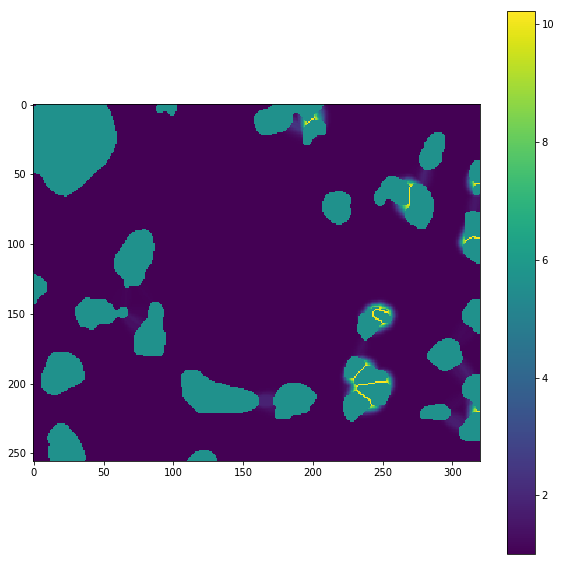

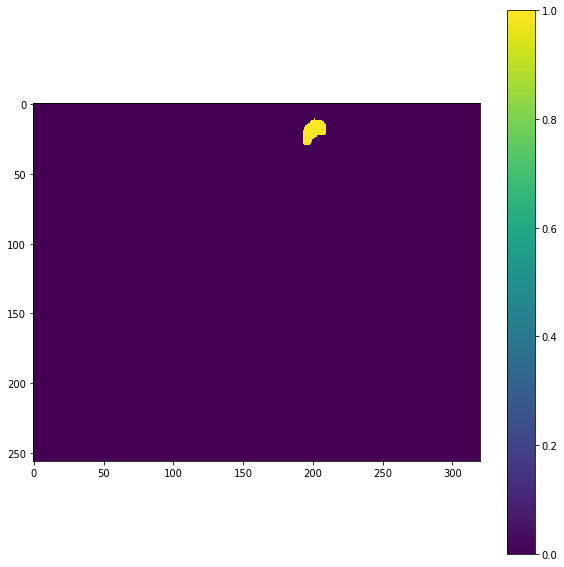

In [68]:
for i in [weights[9], masks[9][1]]:
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 10)
    img = ax.imshow(i)
    fig.colorbar(img)

# UNET

In [ ]:
n = net.u_net()

In [ ]:
# Run something through it as a sanity check
inp = Variable(torch.randn(1, 1, 572, 572))
n(inp).shape